In [1]:
import numpy as np
import pandas as pd

## Q1

1.1 Load the data

In [3]:
df_invoices = pd.read_json("invoices.json")
df_invoices = df_invoices[~df_invoices["InvoiceNo"].str.startswith("C")]
df_items = pd.read_json("items.json") 
df_purchases = pd.read_json("purchases.json")
df_purchases = df_purchases[~df_purchases["InvoiceNo"].str.startswith("C")]
df_purchases["StockCode"] = df_purchases["StockCodeSC"].str.extract("SC(.+)")
df_total = df_purchases.merge(df_items, how="left", on="StockCode")
df_total["Revenue"] = df_total["Quantity"] * df_total["UnitPrice"] * 1.25
df_total = df_total.dropna(how="any", axis=0)

1.2 What fraction of invoices were shipped? 

In [4]:
df = pd.read_json("invoices.json")
len(df_invoices) / len(df)

0.8520988320548896

1.3 How many unique customers are there (regardless of shipped or not)? 

In [5]:
len(pd.read_json("invoices.json")["CustomerID"].drop_duplicates())

4373

1.4 What the total number of unique items with a unit price greater than 2? 

In [6]:
(df_items.drop_duplicates(subset=["Description"])["UnitPrice"] > 2).sum()

2164

1.5 Are there any columns with null values? 

In [7]:
nan_columns = set()
for df in [df_invoices, df_items, df_purchases]:
    nan_columns = nan_columns | (set(df.columns) - set(df.dropna(how="any", axis=1).columns))
nan_columns


{'CustomerID', 'Description'}

1.6 Thinking ahead, how do you think you would join the different tables? Please share 2-3 sentences about your approach

I'd like to use left join twice, where the left table is always the purchases because it has two fields "StockCode" and "InvoiceNo" can be used as the key to join on from invoices and items respectively. What's more, every purchases is unique, but multiple purchases may corresponding to same invoice, therefore each of them need to be analyzed

## Q2

2.1 For each customer calculate how many shipped invoices they have placed. List the top 10 customers who have placed an invoice in descending order

In [8]:
df_invoices_num = df_invoices.dropna(how="any", axis=0).groupby(["CustomerID"]).count()["InvoiceNo"]
df_invoices_num.name = "InvoiceNum"
df_invoices_num.sort_values(ascending=False).iloc[:10]

CustomerID
12748.0    211
14911.0    202
17841.0    124
13089.0     97
14606.0     95
15311.0     91
12971.0     86
14646.0     74
16029.0     63
13408.0     62
Name: InvoiceNum, dtype: int64

2.2 Perform a similar calculation but instead of the number of invoices, calculate the average quantity of items per invoice for each customer. List the top 10 customers in descending order

In [9]:
df_purchases_invoice = df_purchases.merge(df_invoices, how="left", on="InvoiceNo")
df_avg_quant = df_purchases_invoice.groupby(["CustomerID"])["Quantity"].sum() / df_invoices_num
df_avg_quant.sort_values(ascending=False).iloc[:10]

CustomerID
12346.0    74215.000000
16446.0    40498.500000
13256.0    12540.000000
18251.0     7824.000000
15749.0     6009.333333
13135.0     4300.000000
16754.0     4280.000000
12415.0     3698.571429
12688.0     3028.000000
15372.0     2924.000000
dtype: float64

2.3 Based on 1 and 2, does it appear that the more invoices a customer have, the smaller the average size of an invoice? Explain your reasoning

In [10]:
df = pd.DataFrame({"QuantAvg":df_avg_quant, "InvoiceNum": df_invoices_num})
q1, q3 = df["QuantAvg"].quantile([0.25, 0.75])
df[(df["QuantAvg"] <= q3)&(df["QuantAvg"] >= q1)].sort_values(["InvoiceNum"])[["InvoiceNum", "QuantAvg"]].corr()

,InvoiceNum,QuantAvg
InvoiceNum,1.000000,0.033011
QuantAvg,0.033011,1.000000


Since the correlation between the invoice num and average quantity is subtle, I think more invoices doesn't necessarily lead to less average invoice size

## Q3

3.1 What is the median item-unit price?

In [11]:
df_items["UnitPrice"].median()

2.51

3.2  What % of items are over $10?

In [12]:
(df_items["UnitPrice"] > 10).sum() / len(df_items) * 100

6.363636363636363

3.3 Generate a histogram of the unit prices. Select reasonable min/max values for the x-axis 

<AxesSubplot:ylabel='Frequency'>

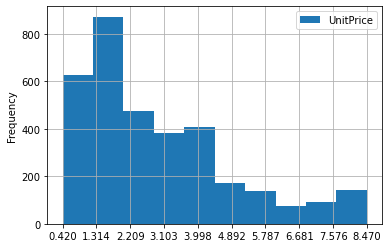

In [13]:
q1, q3 = df_items["UnitPrice"].quantile([0.1, 0.9])
df_items[(df_items["UnitPrice"] >= q1) & (df_items["UnitPrice"] <= q3)].plot.hist(by="UnitPrice", legend=True, grid=True, xticks=np.linspace(q1, q3, 10))

## Q4

4.1 What are the top 10 most ordered items (Quantity) in descending order?  

In [14]:
df = df_total.groupby(["StockCode"])["Quantity"].sum().dropna().sort_values(ascending=False)
df.reset_index().merge(df_items, on="StockCode", how="left").iloc[:10]

,StockCode,Quantity,Description,UnitPrice
0,23843,80995,"PAPER CRAFT , LITTLE BIRDIE",2.08
1,23166,78033,MEDIUM CERAMIC TOP STORAGE JAR,1.04
2,22197,56921,SMALL POPCORN HOLDER,0.72
3,84077,55047,WORLD WAR 2 GLIDERS ASSTD DESIGNS,0.29
4,85099B,48478,JUMBO BAG RED RETROSPOT,1.65
5,85123A,41408,WHITE HANGING HEART T-LIGHT HOLDER,2.55
6,21212,36419,PACK OF 72 RETROSPOT CAKE CASES,0.42
7,84879,36301,ASSORTED COLOUR BIRD ORNAMENT,1.69
8,23084,30754,RABBIT NIGHT LIGHT,2.08
9,22492,26633,MINI PAINT SET VINTAGE,0.65


4.2 What are the top 10 most frequently ordered by customers in descending order? 

In [15]:
df = df_total.groupby(["StockCode"])["Quantity"].count()
df.name = "Frequency"
df = df.reset_index().merge(df_items, on="StockCode", how="left")
df.sort_values("Frequency",ascending=False).iloc[:10]

,StockCode,Frequency,Description,UnitPrice
3367,85123A,2271,WHITE HANGING HEART T-LIGHT HOLDER,2.55
3347,85099B,2115,JUMBO BAG RED RETROSPOT,1.65
1293,22423,2022,REGENCY CAKESTAND 3 TIER,10.95
2643,47566,1707,PARTY BUNTING,9.32
173,20725,1595,LUNCH BAG RED RETROSPOT,1.65
3158,84879,1490,ASSORTED COLOUR BIRD ORNAMENT,1.69
1093,22197,1426,SMALL POPCORN HOLDER,0.72
1576,22720,1403,SET OF 3 CAKE TINS PANTRY DESIGN,4.95
433,21212,1370,PACK OF 72 RETROSPOT CAKE CASES,0.42
175,20727,1328,LUNCH BAG BLACK SKULL.,1.65


4.3 What are the top 5 invoices that generated the most revenue? (Revenue is calculated by marking up the unit price by 25%.)

In [16]:
df = df_total.groupby(["InvoiceNo"])["Revenue"].sum()
df.sort_values(ascending=False).iloc[:5]

InvoiceNo
547966    712212.5000
581483    210587.0000
541431     96479.5000
556255     37305.0000
556917     34545.9125
Name: Revenue, dtype: float64

## Q5

5.1 Discretize customers into quartiles (Q1, Q2, Q3, Q4) using dummy variables based on the total revenue they have generated for the company

In [17]:
revenue = df_total.groupby(["CustomerID"])["Revenue"].sum()
bins = revenue.quantile(np.linspace(0,1,5))
df = pd.DataFrame(pd.cut(revenue, bins))
df.columns = ["RevenueSeg"]
df["Revenue"] = revenue
pd.get_dummies(pd.cut(revenue, bins))

KeyError: 'CustomerID'

5.2 How much revenue is generated in total by each segment?

In [18]:
df.groupby(["RevenueSeg"])["Revenue"].sum()

KeyError: 'RevenueSeg'

5.3 Using the pivot table function, create a table that displays the average order quantity of each stock code for a given segment

In [258]:
df_seg = df.reset_index().merge(df_total, how="right", on="CustomerID")
df_quant = pd.pivot_table(df_seg, index=["RevenueSeg", "StockCode"], values="Quantity", aggfunc=np.sum)
df_num = pd.pivot_table(df_seg, index=["RevenueSeg", "StockCode"], values="Quantity", aggfunc=len)
(df_quant / df_num).rename(columns={"Quantity": "AvgQuantity"})

AvgQuantity
RevenueSeg             StockCode             
(5.312, 413.962]       10002         1.000000
                       10080              NaN
                       10120         3.000000
                       10125         2.000000
                       10133        10.888889
...                                       ...
(2266.081, 498689.513] 90191         6.000000
                       90192         3.142857
                       90194         1.666667
                       90204         2.800000
                       90208         2.666667

[10996 rows x 1 columns]